## Transaction
一个transaction由四部分组成：version，inputs，outputs，locktime
version（4个字节）|inputs的数目（varint）|inputs|outputs的数目（varint）|outputs|locktime（4个字节）

### varint

可变的长度

<253, 1 byte

253~2¹⁶-1, 2 bytes, 0xfd+（2字节长度）

2¹⁶~2³²-1, 4 bytes, 0xfe+(4字节长度) 

2³² ~ 2⁶⁴-1, 8 bytes, 0xff+(8字节长度)
### Sequence and Locktime

### Version

OP_CHECKSEQUENCEVERIFY： version >1

### Inputs

prev_index(32字节）|prev_index(4字节)|scriptSig的长度|scriptSig|sequence（4个字节）

1. previous tx id(32字节)
2. previous tx index(4字节)
3. scriptSig
4. sequence(4字节)
### Outputs
amount(8字节)| script_pubkey的长度|script_pubkey
1. amount(8字节)
2. script_pub_key
### Locktime
1. 4字节

## 验证交易
1. input必须是previous unspent（避免双花）
2. sum(inputs) > sum(outputs) 除了coinbase的交易
3. ScriptSig 可以unlock previous ScriptPubKey
验证签名需要三个数据（signature Hash Z， Public key P， Signature（r,s））
### 如何生成signature Hash
1. 将交易里面的签名部分清空，用0x00替代

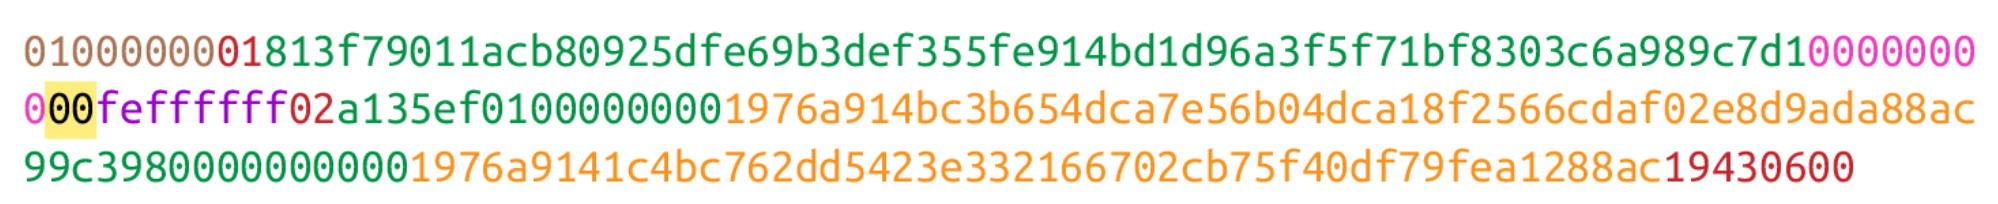

2. 在签名部分用该input指向的前一个交易的Script Public Key 替换

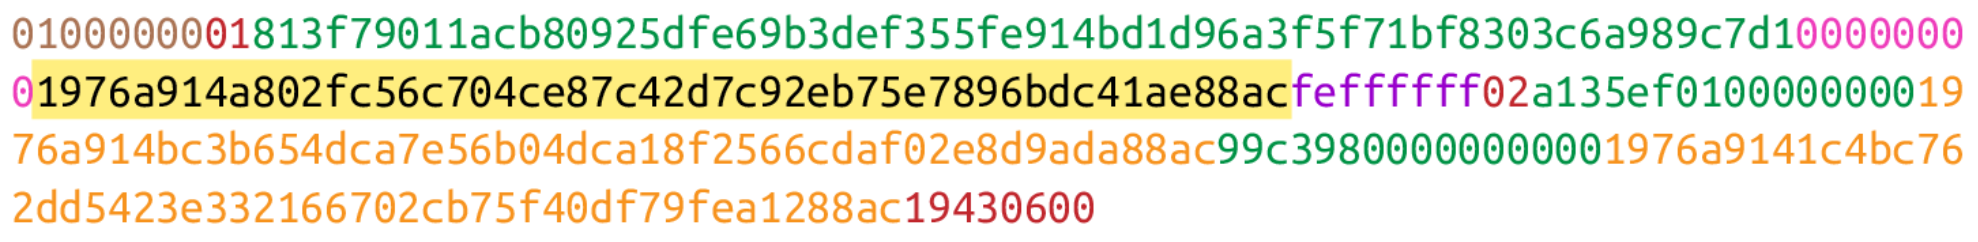

3. 在后面追加Hash type（4字节）

SIGHASH_ALL: 验证所有的输入输出
SIGHASH_SINGLE：验证某一个输出
SIGHASH_NONE：不验证输出

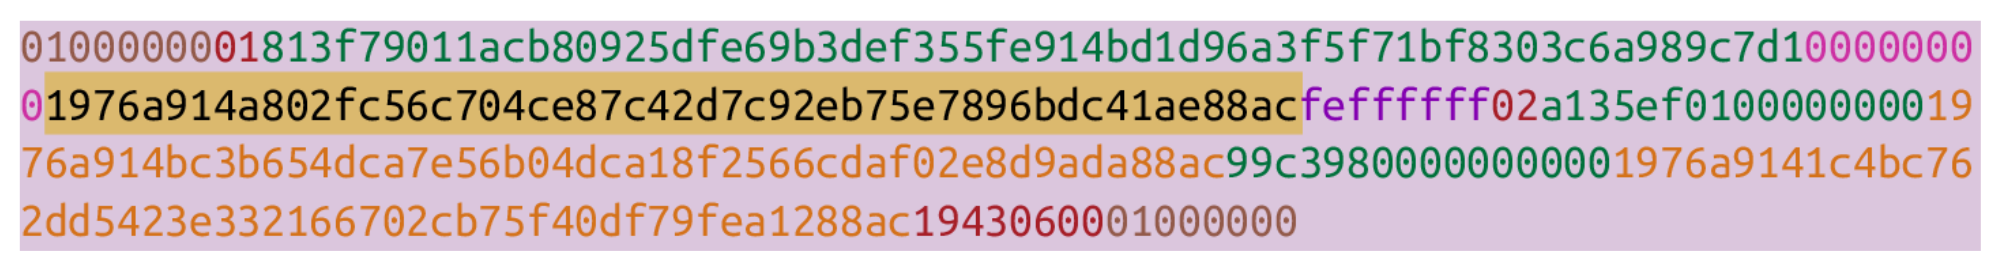

In [1]:
from tx import Tx
from io import BytesIO
raw_tx = ('0100000001813f79011acb80925dfe69b3def355fe914bd1d96a3f5f71bf8303c6a989c7d1000000006b483045022100ed81ff192e75a3fd2304004dcadb746fa5e24c5031ccfcf21320b0277457c98f02207a986d955c6e0cb35d446a89d3f56100f4d7f67801c31967743a9c8e10615bed01210349fc4e631e3624a545de3f89f5d8684c7b8138bd94bdd531d2e213bf016b278afeffffff02a135ef01000000001976a914bc3b654dca7e56b04dca18f2566cdaf02e8d9ada88ac99c39800000000001976a9141c4bc762dd5423e332166702cb75f40df79fea1288ac19430600')
stream = BytesIO(bytes.fromhex(raw_tx))
tx=Tx.parse(stream)
print(tx.fee())

parse tx: version: 1, locktime: 410393
tx_in: d1c789a9c60383bf715f3f6ad9d14b91fe55f3deb369fe5d9280cb1a01793f81:0:3045022100ed81ff192e75a3fd2304004dcadb746fa5e24c5031ccfcf21320b0277457c98f02207a986d955c6e0cb35d446a89d3f56100f4d7f67801c31967743a9c8e10615bed01 0349fc4e631e3624a545de3f89f5d8684c7b8138bd94bdd531d2e213bf016b278a

tx_out: 32454049:OP_DUP OP_HASH160 bc3b654dca7e56b04dca18f2566cdaf02e8d9ada OP_EQUALVERIFY OP_CHECKSIG

tx_out: 10011545:OP_DUP OP_HASH160 1c4bc762dd5423e332166702cb75f40df79fea12 OP_EQUALVERIFY OP_CHECKSIG

TxFetcher fetch transactions: https://blockstream.info/api//tx/d1c789a9c60383bf715f3f6ad9d14b91fe55f3deb369fe5d9280cb1a01793f81/hex

parse tx: version: 1, locktime: 0
tx_in: cbf43825e0b92ba3bfabaec509e14ee9132df1e92ffdfc6636f848fbf0537c13:0:304402207e6009ad86367fc4b166bc80bf10cf1e78832a01e9bb491c6d126ee8aa436cb502200e29e6dd7708ed419cd5ba798981c960f0cc811b24e894bff072fea8074a7c4c01 03bc9e7397f739c70f424aa7dcce9d2e521eb228b0ccba619cd6a0b9691da796a1

tx_in: 590133d

In [2]:
from helper import hash256
from ecc import S256Point,Signature
sec = bytes.fromhex('0349fc4e631e3624a545de3f89f5d8684c7b8138bd94bdd531d2e213bf016b278a')
der = bytes.fromhex('3045022100ed81ff192e75a3fd2304004dcadb746fa5e24c5031c\
cfcf21320b0277457c98f02207a986d955c6e0cb35d446a89d3f56100f4d7f67801c31967743a9\
c8e10615bed')
print(123)
modified_tx = bytes.fromhex('0100000001813f79011acb80925dfe69b3def355fe914\
bd1d96a3f5f71bf8303c6a989c7d1000000001976a914a802fc56c704ce87c42d7c92eb75e7896\
bdc41ae88acfeffffff02a135ef01000000001976a914bc3b654dca7e56b04dca18f2566cdaf02\
e8d9ada88ac99c39800000000001976a9141c4bc762dd5423e332166702cb75f40df79fea1288a\
c1943060001000000')
h256 = hash256(modified_tx)
z = int.from_bytes(h256, 'big')
print(hex(z))
point = S256Point.parse(sec)
signature = Signature.parse(der)
point.verify(z, signature)

123
0x27e0c5994dec7824e56dec6b2fcb342eb7cdb0d0957c2fce9882f715e85d81a6


True

In [3]:
# 创建交易
from helper import decode_base58,SIGHASH_ALL,little_endian_to_int,decode_base58
from script import p2pkh_script, Script
from tx import TxIn, TxOut, Tx
prev_tx = bytes.fromhex('b1af04cff9ff3284135a0aa15402bf9fbd0ef8e1e376bc50c7251f17ee45e8e6')
prev_index=0
tx_in=TxIn(prev_tx,prev_index)
change_amount = int(700*100000000)
change_h160 = decode_base58('2MtWnBSZFRgGvNNy6b43CXiCZeRoqZsVXzP')
change_script = p2pkh_script(change_h160)
print('change_h160', change_h160)
change_output=TxOut(change_amount,change_script)
target_amount=int(20000*100000000)
target_h160 = decode_base58('2MxWT6eEmjnhyzGjo5q9qppCF4e6ng9eNqc')
print('target_h160', target_h160)
target_script=p2pkh_script(target_h160)
target_output=TxOut(target_amount,target_script)
tx_obj=Tx(1,[tx_in],[change_output,target_output],0,True)
print(tx_obj)
# 签交易
from ecc import PrivateKey
from helper import SIGHASH_ALL
z=tx_obj.sig_hash(0)
secret=77067741328863406280043135364701724382609223327125270105262968121339365559745
private_key = PrivateKey(secret)
print('public key', private_key.point.sec().hex())
print('address:', private_key.point.address(compressed=True,testnet=True))
der = private_key.sign(z).der()
sig = der + SIGHASH_ALL.to_bytes(1, 'big')
sec = private_key.point.sec()
script_sig = Script([sig, sec])
tx_obj.tx_ins[0].script_sig = script_sig
print(tx_obj.serialize().hex())
tx_obj.verify_input(0)

change_h160 b'\r\xe9<\xf0\xb99\x86\xa7\xef)\xb3$\xc5\x9a\xd2\xc8S6\x83d'
target_h160 b'9\xb9\xcf\xcc\xcd*\x8e\xc9\xbb4\x07p\xf9\xf3M\xaa\x1b\xf3ft'
tx: 27474e2844490a932a10d16f514268360e0d8233c72bbf010362448e1771ae67
version: 1
tx_ins:
b1af04cff9ff3284135a0aa15402bf9fbd0ef8e1e376bc50c7251f17ee45e8e6:0:
tx_outs:
70000000000:OP_DUP OP_HASH160 0de93cf0b93986a7ef29b324c59ad2c853368364 OP_EQUALVERIFY OP_CHECKSIG
2000000000000:OP_DUP OP_HASH160 39b9cfcccd2a8ec9bb340770f9f34daa1bf36674 OP_EQUALVERIFY OP_CHECKSIG
locktime: 0
TxFetcher fetch transactions: https://blockstream.info/testnet/api//tx/b1af04cff9ff3284135a0aa15402bf9fbd0ef8e1e376bc50c7251f17ee45e8e6/hex

parse tx: version: 2, locktime: 1144014594
tx_in: 0c1677122d9d1b0791e8a0fbba2ac449378663692ea2ff3e788ae6dd5717da54:1:0014791b7fcc5dbf70bbaa83155bd889042a4ab1fe4e

tx_out: 21700:OP_HASH160 55eeb7ce28b47cf66be61a505946efb9792a5691 OP_EQUAL

public key 02ff04c9736818e1965dbf97c641918fbdfc1852150b7ab425750f719b02870908
address: n4bPMLopLX

False